In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn

c:\Users\akhde\OneDrive\Desktop\MLOps\Loan-Fraud-Detection\.venv\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [2]:
df = pd.read_csv('C:/Users/akhde/OneDrive/Desktop/MLOps/Loan-Fraud-Detection/data/raw/personality_dataset.csv')

In [3]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [4]:
df.shape

(2900, 8)

In [5]:
df = df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2512 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2451 non-null   float64
 1   Stage_fear                 2439 non-null   object 
 2   Social_event_attendance    2451 non-null   float64
 3   Going_outside              2447 non-null   float64
 4   Drained_after_socializing  2461 non-null   object 
 5   Friends_circle_size        2437 non-null   float64
 6   Post_frequency             2449 non-null   float64
 7   Personality                2512 non-null   object 
dtypes: float64(5), object(3)
memory usage: 176.6+ KB


In [7]:
df.isnull().mean()

Time_spent_Alone             0.024283
Stage_fear                   0.029061
Social_event_attendance      0.024283
Going_outside                0.025876
Drained_after_socializing    0.020303
Friends_circle_size          0.029857
Post_frequency               0.025080
Personality                  0.000000
dtype: float64

In [8]:
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [9]:
for i in num_cols:
    df[i] = df[i].fillna(df[i].median())

for i in cat_cols:
    df[i] = df[i].fillna(df[i].mode()[0])

In [10]:
df.shape

(2512, 8)

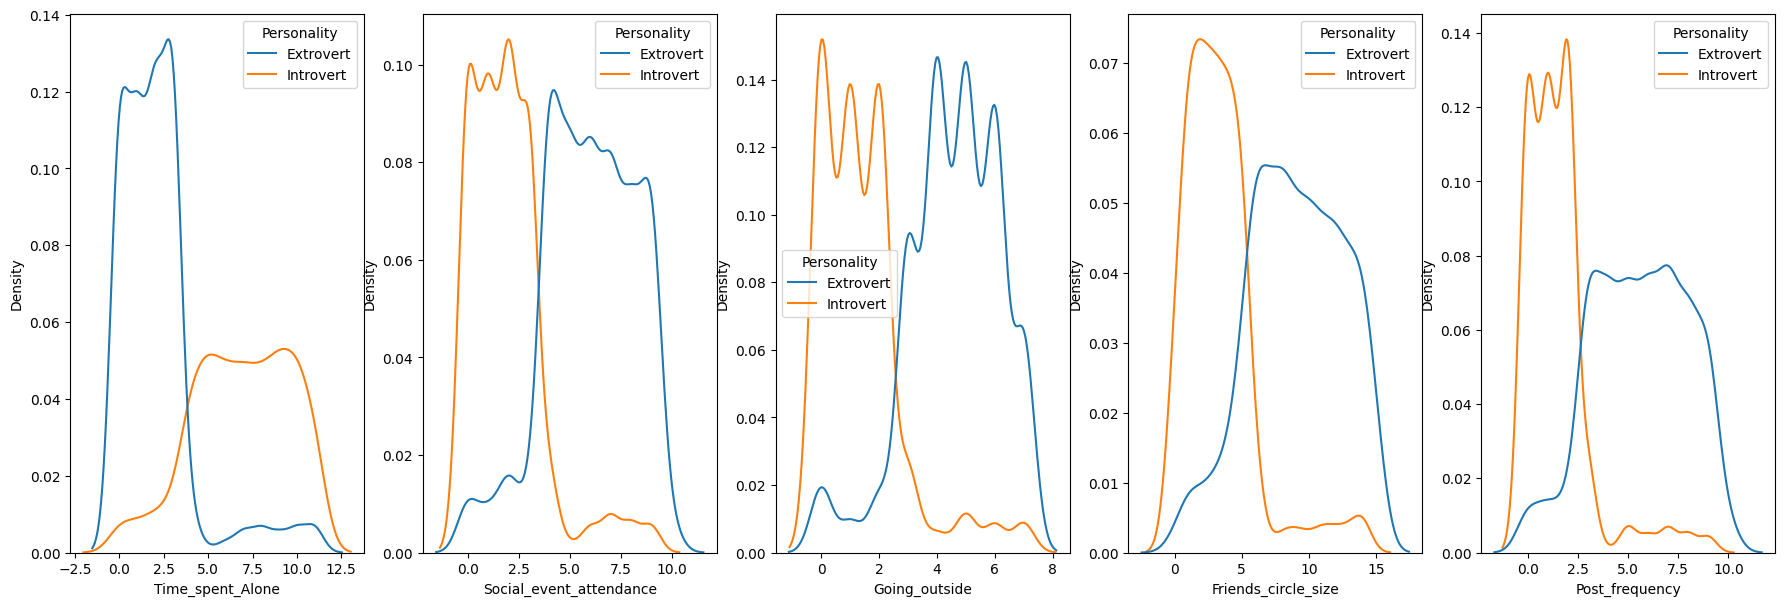

In [11]:
fig, ax = plt.subplots(1,5,figsize=(22,7))
for i,col in enumerate(num_cols):
    sns.kdeplot(ax=ax[i],data=df,x=col,hue='Personality')

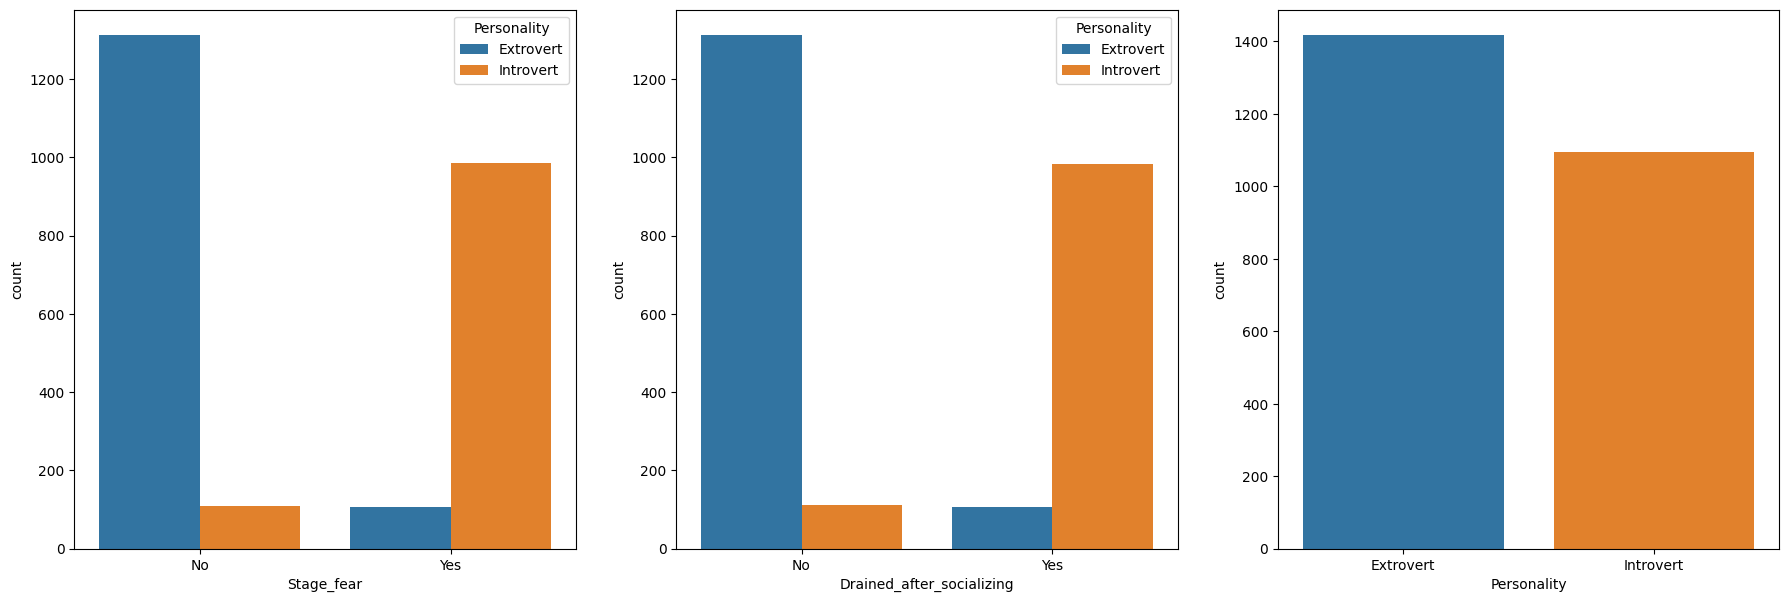

In [12]:
fig, ax = plt.subplots(1,3,figsize=(22,7))
for i,col in enumerate(cat_cols):
   sns.countplot(ax=ax[i],data=df,x=col,hue='Personality')

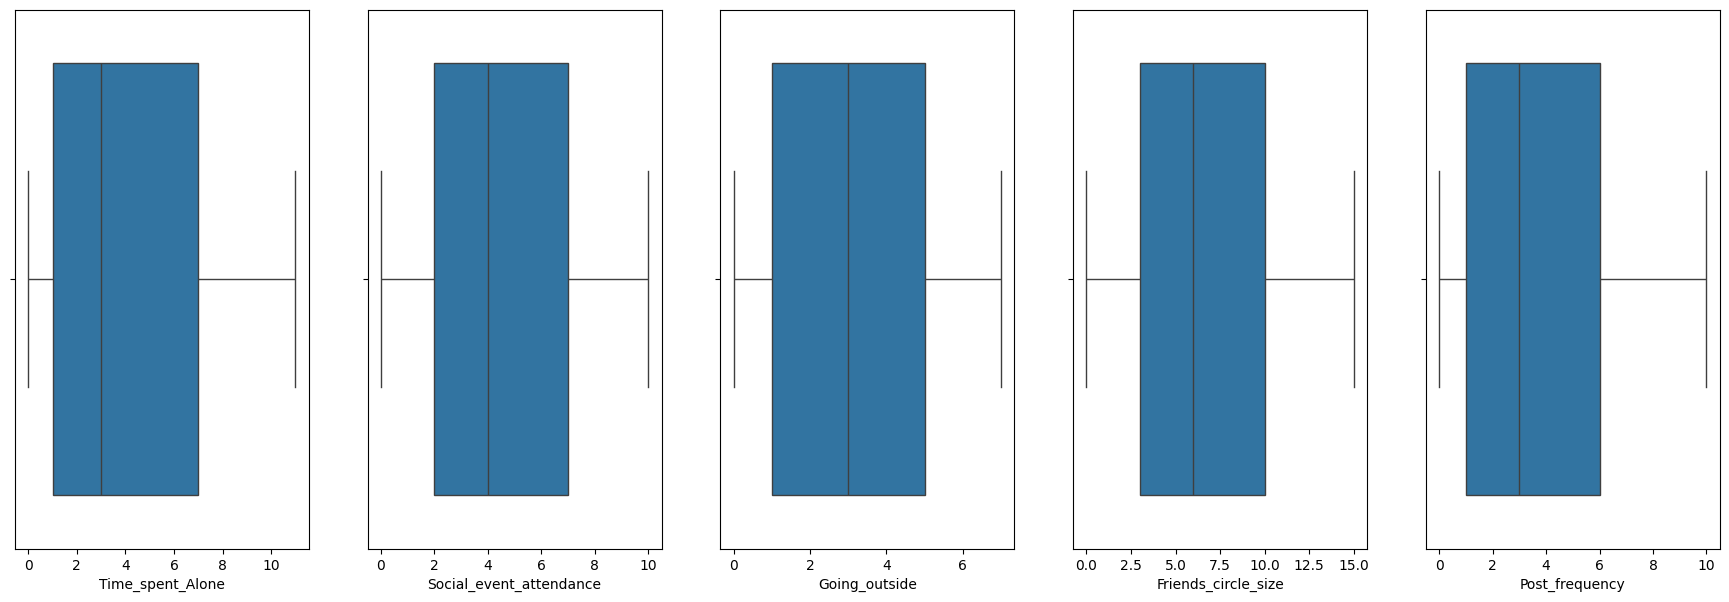

In [13]:
fig, ax = plt.subplots(1,5,figsize=(22,7))
for i,col in enumerate(num_cols):
    sns.boxplot(ax=ax[i],data=df,x=col)

<Axes: >

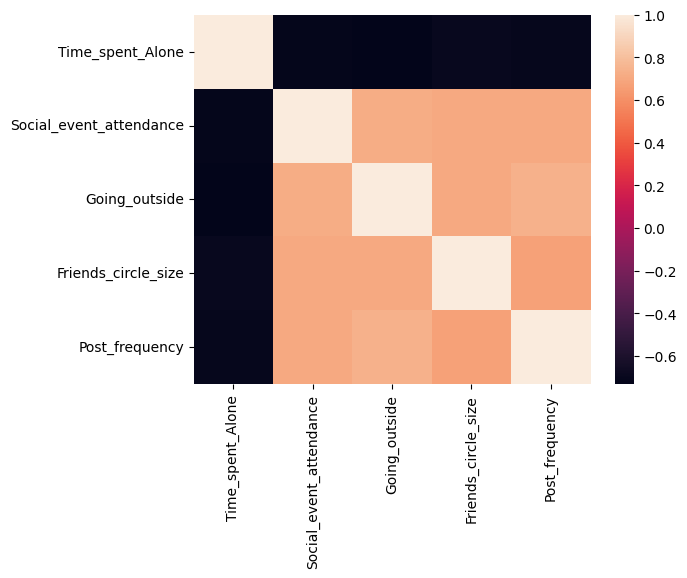

In [14]:
cor = df[num_cols].corr()
sns.heatmap(cor)

In [15]:
df[num_cols].corr()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
Time_spent_Alone,1.000000,-0.716721,-0.731662,-0.697095,-0.707069
Social_event_attendance,-0.716721,1.000000,0.717681,0.704123,0.707747
Going_outside,-0.731662,0.717681,1.000000,0.706356,0.739670
Friends_circle_size,-0.697095,0.704123,0.706356,1.000000,0.669560
Post_frequency,-0.707069,0.707747,0.739670,0.669560,1.000000


In [16]:
from scipy.stats import ttest_ind

results = []
for col in num_cols:
    if col != 'Personality':
        intro = df[df['Personality']=='Introvert'][col]
        extro = df[df['Personality']=='Extrovert'][col]
        t_stat, p_val = ttest_ind(intro, extro)
        results.append((col, t_stat, p_val))

pd.DataFrame(results, columns=['feature', 't_statistic', 'p_value']).sort_values('p_value')

,feature,t_statistic,p_value
0,Time_spent_Alone,48.910987,0.000000e+00
1,Social_event_attendance,-48.834735,0.000000e+00
2,Going_outside,-51.009649,0.000000e+00
4,Post_frequency,-48.283524,0.000000e+00
3,Friends_circle_size,-44.261472,8.870503e-317


In [17]:
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


## Feature Engineering

In [18]:
df1 = df.copy()

In [19]:
df1['Offline_social_activity'] = df1['Social_event_attendance'] * df1['Going_outside']
# df1['Friends_size_level'] = pd.qcut(df1['Friends_circle_size'],q=4,labels=['low', 'med', 'high', 'very_high'])
# df1['Online_vs_Offline'] = df1['Post_frequency'] / (df1['Offline_social_activity'] + 1)

In [20]:
df1.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Offline_social_activity
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert,24.0
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert,0.0
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert,2.0
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert,42.0
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert,36.0


<Axes: >

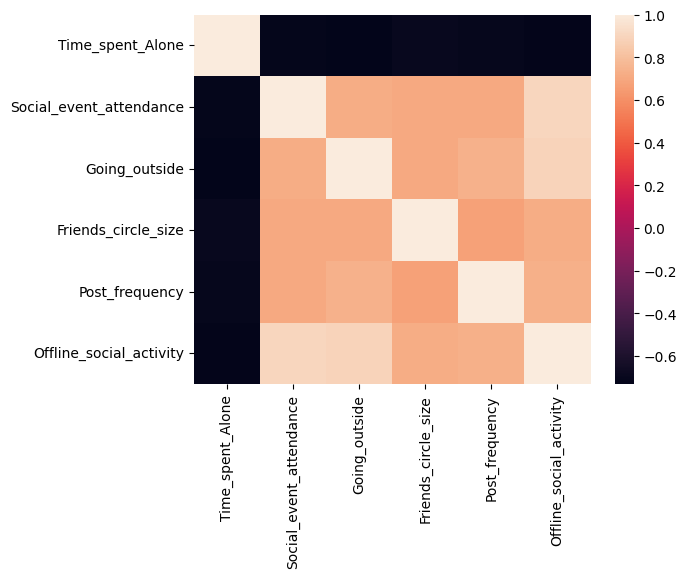

In [21]:
num_cols1 = df1.select_dtypes(include='number').columns.tolist()
sns.heatmap(df1[num_cols1].corr())

## Model Building

In [22]:
cat_cols1 = df1.select_dtypes(include=['object','category']).columns.tolist()
le = LabelEncoder()
for i in cat_cols1:
    df1[i] = le.fit_transform(df1[i])

df1.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Offline_social_activity
0,4.0,0,4.0,6.0,0,13.0,5.0,0,24.0
1,9.0,1,0.0,0.0,1,0.0,3.0,1,0.0
2,9.0,1,1.0,2.0,1,5.0,2.0,1,2.0
3,0.0,0,6.0,7.0,0,14.0,8.0,0,42.0
4,3.0,0,9.0,4.0,0,8.0,5.0,0,36.0


In [23]:
target = df1['Personality']
features = df1.drop(columns=['Personality'],axis=1)

In [24]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [28]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("notebook_experiments")

2025/06/13 00:03:44 INFO mlflow.tracking.fluent: Experiment with name 'notebook_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/613478805149268938', creation_time=1749753224035, experiment_id='613478805149268938', last_update_time=1749753224035, lifecycle_stage='active', name='notebook_experiments', tags={}>

In [29]:
linear_models_params = {
    'logistic_regression' : {
        'model' : LogisticRegression(),
        'params' : {
            'classifier__solver': ['liblinear','saga'],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.01, 0.1, 1,10]
        }
    },
    'SVC' : {
        'model' : SVC(),
        'params' : {
            'classifier__kernel' : ['rbf','linear'],
            'classifier__C' : [0.01,0.1,1,10]
        }
    }
}

for name,config in linear_models_params.items():
    pipe = Pipeline([
        ('classifier' ,config['model']) 
    ])
    gs = GridSearchCV(pipe,cv=5,scoring='accuracy',param_grid=config['params'],n_jobs=-1)

    with mlflow.start_run() as parent : 
        gs.fit(X_train_scaled,y_train)
        for i in range(len(gs.cv_results_['params'])):

            with mlflow.start_run(nested=True) as child:
                mlflow.log_params(gs.cv_results_['params'][i])
                mlflow.log_metric('accuracy',gs.cv_results_['mean_test_score'][i])

        mlflow.log_params(gs.best_params_)
        mlflow.log_metric('accuracy',gs.best_score_)

        mlflow.sklearn.log_model(gs.best_estimator_,name)

        

    print(f"\n{name}:\nBest Params: {gs.best_params_}\nBest Accuracy: {gs.best_score_}\n {gs.best_estimator_}")

        


logistic_regression:
Best Params: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Accuracy: 0.925334673267081
 Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))])

SVC:
Best Params: {'classifier__C': 0.01, 'classifier__kernel': 'rbf'}
Best Accuracy: 0.9258321857048919
 Pipeline(steps=[('classifier', SVC(C=0.01))])


In [33]:
tree_models_params = {
    'Random_Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [5,8,10],
            'classifier__min_samples_split': [2, 5],
        }
    },
    'XGBoost' : {
        'model' : XGBClassifier(),
        'params' : {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1],
        }
    }
}

for name,config in tree_models_params.items():
    pipe = Pipeline([
        ('classifier' ,config['model']) 
    ])
    gs = GridSearchCV(pipe,cv=5,scoring='accuracy',param_grid=config['params'],n_jobs=-1)
    
    with mlflow.start_run() as parent :
        gs.fit(X_train,y_train)

        for i in range(len(gs.cv_results_['params'])):
            with mlflow.start_run(nested=True) as child:
                mlflow.log_params(gs.cv_results_['params'][i])
                mlflow.log_metric('accuracy',gs.cv_results_['mean_test_score'][i])
        
        mlflow.log_params(gs.best_params_)
        mlflow.log_metric('accuracy',gs.best_score_)

        mlflow.sklearn.log_model(gs.best_estimator_,name)
    print(f"\n{name}:\nBest Params: {gs.best_params_}\nBest Accuracy: {gs.best_score_}")


Random_Forest:
Best Params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best Accuracy: 0.9258321857048919

XGBoost:
Best Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best Accuracy: 0.925334673267081


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       282
           1       0.92      0.92      0.92       221

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



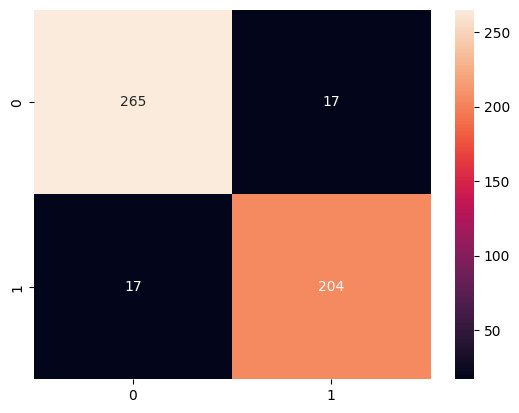

In [41]:
C=0.01
penalty='l1'
solver='liblinear'
lor = LogisticRegression(C=C,penalty=penalty,solver=solver)

with mlflow.start_run():
    lor.fit(X_train_scaled,y_train)

    y_pred = lor.predict(X_test_scaled)
    report = classification_report(y_test,y_pred)
    print(report)
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

    with open("classification_report_lor.txt", "w") as f:
        f.write(report)
    
    mlflow.log_artifact("classification_report_lor.txt")
    mlflow.log_param('C',C)
    mlflow.log_param('penalty',penalty)
    mlflow.log_param('solver',solver)
    mlflow.sklearn.log_model(lor,'Logistic_Regression')
    mlflow.set_tags({'model':'Logistic Regression'})

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       282
           1       0.92      0.92      0.92       221

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



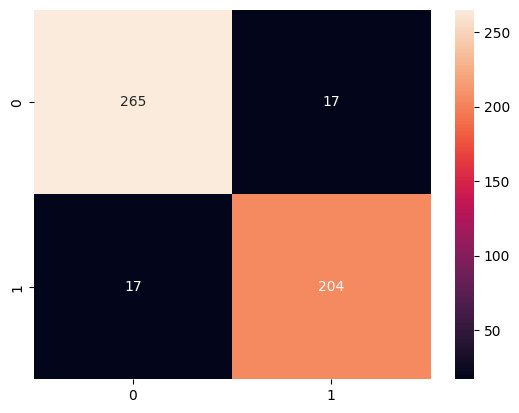

In [42]:
C=0.01
kernel='rbf'
sv = SVC(C=C,kernel=kernel)
with mlflow.start_run():
    sv.fit(X_train_scaled,y_train)

    y_pred = sv.predict(X_test_scaled)
    report = classification_report(y_test,y_pred)
    print(report)
    with open("classification_report_svc.txt", "w") as f:
        f.write(report)
    
    mlflow.log_artifact("classification_report_svc.txt")
    mlflow.log_param('C',C)
    mlflow.log_param('kernel',kernel)
    mlflow.set_tags({'model':'SVC'})
    mlflow.sklearn.log_model(sv,'SVC')

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       282
           1       0.92      0.92      0.92       221

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



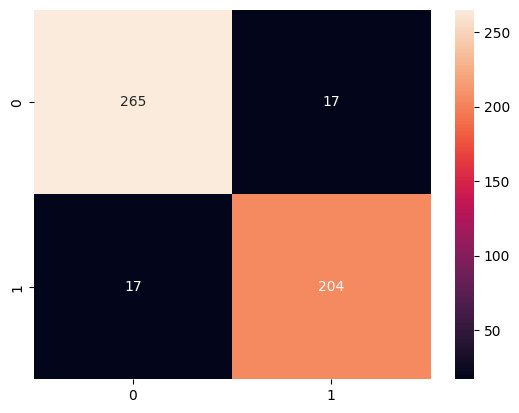

In [44]:
max_depth =5
min_samples_split= 2
n_estimators =50
rfc = RandomForestClassifier(max_depth =max_depth,min_samples_split= min_samples_split, n_estimators =n_estimators)
with mlflow.start_run():
    rfc.fit(X_train,y_train)

    y_pred = rfc.predict(X_test)
    report = classification_report(y_test,y_pred)
    print(report)

    with open("classification_report_rfc.txt", "w") as f:
        f.write(report)
    
    mlflow.log_artifact("classification_report_rfc.txt")
    mlflow.log_param('max_depth',max_depth)
    mlflow.log_param('min_samples_split',min_samples_split)
    mlflow.log_param('n_estimators',n_estimators)
    mlflow.set_tags({'model':'Random Forest'})
    mlflow.sklearn.log_model(rfc,'Random_Forest')

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       282
           1       0.92      0.92      0.92       221

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



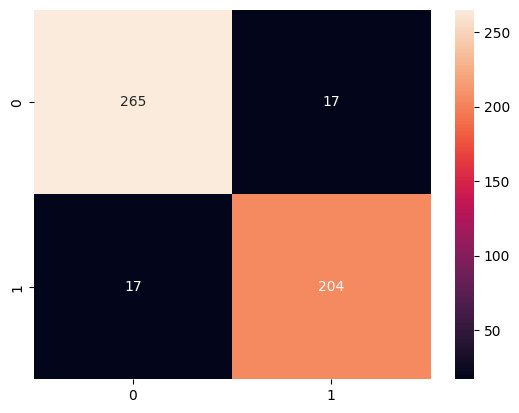

In [43]:
learning_rate = 0.01
max_depth = 3
n_estimators = 100
xgb = XGBClassifier(learning_rate = learning_rate,max_depth = max_depth, n_estimators = n_estimators)
with mlflow.start_run():
    xgb.fit(X_train,y_train)

    y_pred = xgb.predict(X_test)
    report = classification_report(y_test,y_pred)
    print(report)

    with open("classification_report_xgb.txt", "w") as f:
        f.write(report)
    
    mlflow.log_artifact("classification_report_xgb.txt")
    mlflow.log_param('learning_rate',learning_rate)
    mlflow.log_param('max_depth',max_depth)
    mlflow.log_param('n_estimator',n_estimators)
    mlflow.set_tags({'model':'XGBoost'})
    mlflow.sklearn.log_model(xgb,'XGBoost')

    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [104]:
a.items()

dict_items([('a', [1, 2, 4]), ('b', [3, 4, 5])])

In [146]:
imp = rfc.feature_importances_
importance = pd.DataFrame({
    'feature' : X_train.columns,
    'imp' : imp
}).sort_values(by='imp',ascending=False)
importance

,feature,imp
1,Stage_fear,0.261188
4,Drained_after_socializing,0.227104
7,Offline_social_activity,0.174900
0,Time_spent_Alone,0.170969
2,Social_event_attendance,0.060077
6,Post_frequency,0.049128
3,Going_outside,0.046327
5,Friends_circle_size,0.010307
